### **Import Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Import Library**

In [0]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf
import keras
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Load Data**

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/COVID-19/')
files = glob.glob('/content/drive/My Drive/Colab Notebooks/COVID-19/DATA/DATA 4/COVID-19/*')
files2=glob.glob('/content/drive/My Drive/Colab Notebooks/COVID-19/DATA/DATA 4/NORMAL/*')
train_imgs = [fn for fn in files+files2]
len(train_imgs)

3600

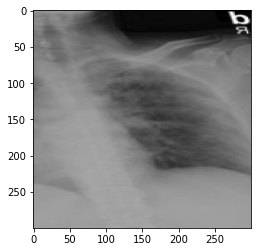

In [0]:
import matplotlib.image as mpimg
for ima in train_imgs[1:2]:
     img=mpimg.imread(ima)
     imgplot = plt.imshow(img)
     plt.show()

### **Data Preparation**

In [0]:
nrows = 224
ncolumns = 224
channels = 3  

def read_and_process_image(list_of_images):
    
    X = [] #images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'Normal' in image:
            y.append(0)
        elif 'Covid-19' in image:
            y.append(1)

    
    return X, y

X, y = read_and_process_image(train_imgs)

Text(0.5, 1.0, 'Total images of each class')

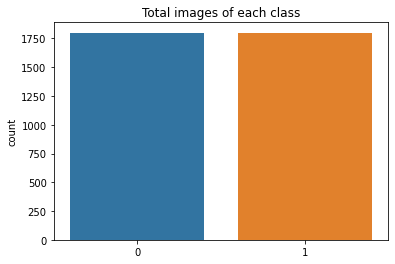

In [0]:
import seaborn as sns
import gc 
gc.collect()

#Convert list to numpy array
X = np.array(X)
y = np.array(y)


#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Total images of each class')

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,stratify=np.array(y),random_state=2)
X_val,X_test,y_val,y_test = train_test_split(X_val, y_val, test_size=0.25,stratify=np.array(y_val),random_state=2)
print('Train:',X_train.shape,y_train.shape)
print('Val:',X_val.shape,y_val.shape)
print('Test:',X_test.shape,y_test.shape)

Train: (2700, 224, 224, 3) (2700,)
Val: (675, 224, 224, 3) (675,)
Test: (225, 224, 224, 3) (225,)


In [0]:
y_train_ohe = pd.get_dummies(y_train)
y_val_ohe=pd.get_dummies(y_val)
y_test_ohe=pd.get_dummies(y_test)

y_train_ohe.shape,y_val_ohe.shape,y_test_ohe.shape

((2700, 2), (675, 2), (225, 2))

### **Model Parameters**

In [0]:
batch_size = 2
EPOCHS = 50
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = 2
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

### **Data Generator**

In [0]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(
                                  rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

test_datagen=tf.keras.preprocessing.image.ImageDataGenerator()

In [0]:
train_generator = train_datagen.flow(X_train, y_train_ohe, batch_size=batch_size)
val_generator = test_datagen.flow(X_val, y_val_ohe, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test_ohe, batch_size=batch_size)

### **Define Model**

In [0]:
input_shape = (224,224,3)
model_input =tf.keras.Input(shape=input_shape)
base_model =tf.keras.applications.InceptionV3(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)
for layer in base_model.layers:
    layer.trainable = True

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 111, 111, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 111, 111, 32) 0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [0]:
Base_model_last_layer = base_model.get_layer('mixed10')
print('last layer output shape:',Base_model_last_layer.output_shape)
Base_model_last_output = Base_model_last_layer.output

last layer output shape: (None, 5, 5, 2048)


In [0]:
x1 =tf.keras.layers.GlobalAveragePooling2D()(Base_model_last_output)
x1 =tf.keras.layers.Dropout(0.5)(x1)
x1 =tf.keras.layers.Dense(2048, activation='relu')(x1)
x1 =tf.keras.layers.Dropout(0.5)(x1)
final_output1 =tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='final_output')(x1)
InceptionV3_model =tf.keras.models.Model(model_input, final_output1)
metric_list = ["accuracy"]
optimizer =tf.keras.optimizers.Adam(lr=1.2500e-05)
InceptionV3_model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
InceptionV3_model.load_weights('/content/drive/My Drive/Colab Notebooks/COVID-19/MODEL/DATA 4/Weights_Finetuning_InceptionV3.h5')

In [0]:
loss_val, acc_val = InceptionV3_model.evaluate(X_val,y_val_ohe,batch_size=1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

675/675 [==============================] - 10s 14ms/step - loss: 0.1158 - accuracy: 0.9585
Validation: accuracy = 0.958519  ;  loss_v = 0.115773


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import accuracy_score, classification_report

In [0]:
Validation_pred =  InceptionV3_model.predict(X_val)
Prdict_label = np.argmax(Validation_pred, -1)
Actual_label = y_val

print('Accuracy on Validation Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Validation Data: 95.85%
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       337
           1       0.94      0.99      0.96       338

    accuracy                           0.96       675
   macro avg       0.96      0.96      0.96       675
weighted avg       0.96      0.96      0.96       675



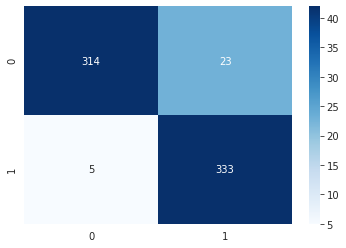

In [0]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(Actual_label , Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_val.shape[0]//16)

In [0]:
loss_test, acc_test =InceptionV3_model.evaluate(X_test,y_test_ohe,batch_size=1, verbose=1)
print("Test: accuracy = %f  ;  loss_v = %f" % (acc_test, loss_test))

225/225 [==============================] - 3s 14ms/step - loss: 0.1859 - accuracy: 0.9467
Test: accuracy = 0.946667  ;  loss_v = 0.185930


In [0]:
Test_predict = InceptionV3_model.predict(X_test)

Prdict_label = np.argmax(Test_predict, -1)
Actual_label = y_test

print('Accuracy on Test Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Test Data: 94.67%
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       113
           1       0.92      0.98      0.95       112

    accuracy                           0.95       225
   macro avg       0.95      0.95      0.95       225
weighted avg       0.95      0.95      0.95       225



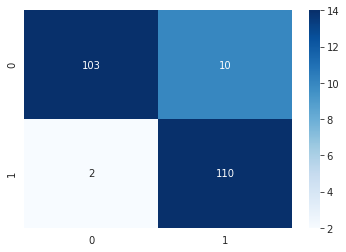

In [0]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(Actual_label, Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_test.shape[0]//16)

In [0]:
Base_model2 =tf.keras.applications.DenseNet201(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)
for layer in Base_model2.layers:
    layer.trainable = True
Base_model2.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [0]:
Base_model2_last_layer = Base_model2.get_layer('relu')
print('last layer output shape:', Base_model2_last_layer.output_shape)
Base_model2_last_output = Base_model2_last_layer.output

last layer output shape: (None, 7, 7, 1920)


In [0]:
x2 =tf.keras.layers.GlobalAveragePooling2D()(Base_model2_last_output)
x2 =tf.keras.layers.Dropout(0.5)(x2)
x2 =tf.keras.layers.Dense(2048, activation='relu')(x2)
x2 =tf.keras.layers.Dropout(0.5)(x2)
final_output2 =tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='final_output2')(x2)
Desnet201_model =tf.keras.models.Model(model_input, final_output2)
metric_list = ["accuracy"]
optimizer = tf.keras.optimizers.Adam(lr=1.2500e-05)
Desnet201_model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
Desnet201_model.load_weights('/content/drive/My Drive/Colab Notebooks/COVID-19/MODEL/DATA 4/Weights_Finetuning_DenseNet201.h5')

In [0]:
loss_val, acc_val = Desnet201_model.evaluate(X_val,y_val_ohe,batch_size=1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

675/675 [==============================] - 19s 28ms/step - loss: 0.0667 - accuracy: 0.9911
Validation: accuracy = 0.991111  ;  loss_v = 0.066729


In [0]:
Validation_pred = Desnet201_model.predict(X_val)
Prdict_label = np.argmax(Validation_pred, -1)
Actual_label = y_val

print('Accuracy on Validation Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Validation Data: 99.11%
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       337
           1       0.99      1.00      0.99       338

    accuracy                           0.99       675
   macro avg       0.99      0.99      0.99       675
weighted avg       0.99      0.99      0.99       675



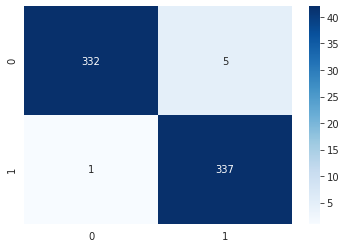

In [0]:
sns.heatmap(confusion_matrix(Actual_label , Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_val.shape[0]//16)

In [0]:
loss_test, acc_test = Desnet201_model.evaluate(X_test,y_test_ohe,batch_size=1, verbose=1)
print("Test: accuracy = %f  ;  loss_v = %f" % (acc_test, loss_test))

225/225 [==============================] - 6s 28ms/step - loss: 0.0971 - accuracy: 0.9822
Test: accuracy = 0.982222  ;  loss_v = 0.097061


In [0]:
Test_predict = Desnet201_model.predict(X_test)

Prdict_label = np.argmax(Test_predict, -1)
Actual_label = y_test

print('Accuracy on Test Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Test Data: 98.22%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       113
           1       1.00      0.96      0.98       112

    accuracy                           0.98       225
   macro avg       0.98      0.98      0.98       225
weighted avg       0.98      0.98      0.98       225



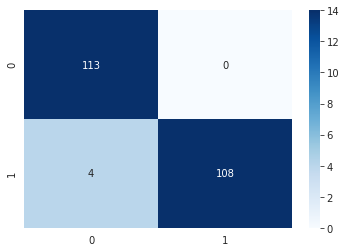

In [0]:
sns.heatmap(confusion_matrix(Actual_label, Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_test.shape[0]//16)

In [0]:
def ensemble(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y =tf.keras.layers.Average()(outputs)
    model =tf.keras.Model(model_input,y,name='ensemble')
    return model

In [0]:
ensemble_model = ensemble([InceptionV3_model, Desnet201_model], model_input)
metric_list = ["accuracy"]
optimizer =tf.keras.optimizers.Adam(lr=1.2500e-05)
ensemble_model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)

In [0]:
loss_val, acc_val = ensemble_model.evaluate(X_val,y_val_ohe,batch_size=1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

675/675 [==============================] - 28s 41ms/step - loss: 0.0517 - accuracy: 0.9867
Validation: accuracy = 0.986667  ;  loss_v = 0.051674


In [0]:
Validation_pred = ensemble_model.predict(X_val)
Prdict_label = np.argmax(Validation_pred, -1)
Actual_label = y_val

print('Accuracy on Validation Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Validation Data: 98.67%
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       337
           1       0.98      0.99      0.99       338

    accuracy                           0.99       675
   macro avg       0.99      0.99      0.99       675
weighted avg       0.99      0.99      0.99       675



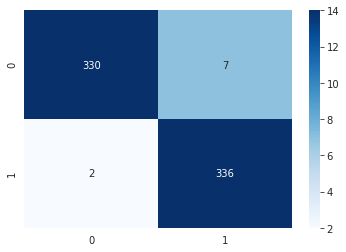

In [0]:
sns.heatmap(confusion_matrix(Actual_label, Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_test.shape[0]//16)

In [0]:
loss_test, acc_test = ensemble_model.evaluate(X_test,y_test_ohe,batch_size=1, verbose=1)
print("Test: accuracy = %f  ;  loss_v = %f" % (acc_test, loss_test))

225/225 [==============================] - 9s 41ms/step - loss: 0.0593 - accuracy: 0.9911
Test: accuracy = 0.991111  ;  loss_v = 0.059271


In [0]:
Test_predict = ensemble_model.predict(X_test)

Prdict_label = np.argmax(Test_predict, -1)
Actual_label = y_test

print('Accuracy on Test Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Test Data: 99.11%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       113
           1       1.00      0.98      0.99       112

    accuracy                           0.99       225
   macro avg       0.99      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225



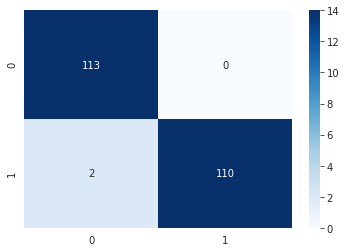

In [0]:
sns.heatmap(confusion_matrix(Actual_label, Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_test.shape[0]//16)

Text(0, 0.5, 'True Positive Rate')

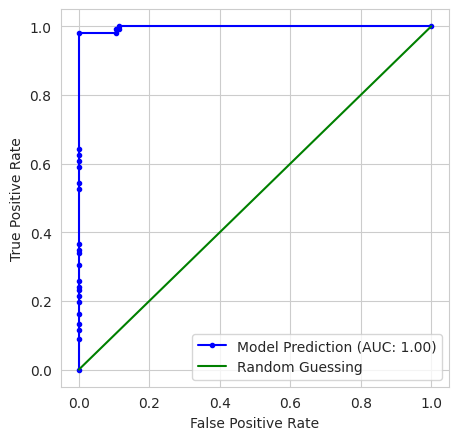

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = Actual_label>0
sick_score = np.sum(Test_predict[:,1:],1)

fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 100)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')